In [95]:
import pandas as pd
import numpy as np
from docplex.cp.model import  CpoModel
import random
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt

In [96]:
def extract_solution(msol, df, extract_dvar_names=None, drop_column_names=None, drop:bool=True):
    df = df.copy()
    """Generalized routine to extract a solution value. 
    Can remove the dvar column from the df to be able to have a clean df for export into scenario."""
    if extract_dvar_names is not None:
        for xDVarName in extract_dvar_names:
            if xDVarName in df.columns:
                df[f'{xDVarName}_Solution'] = [msol.get_value(dvar)   for dvar in df[xDVarName]]  #dvar.solution_value
                if drop:
                    df = df.drop([xDVarName], axis = 1)
    if drop and drop_column_names is not None:
        for column in drop_column_names:
            if column in df.columns:
                df = df.drop([column], axis = 1)
    return df    

In [97]:
N = 10
data = pd.DataFrame({})
data['location'] = ["L"+str(i) for i in np.arange(0,N)]
data['x'] = [random.random() for i in range(0,10)]
data['y'] = [random.random() for i in range(0,10)]
data

,location,x,y
0,L0,0.716894,0.329482
1,L1,0.724364,0.688212
2,L2,0.344161,0.988542
3,L3,0.624408,0.138690
4,L4,0.725201,0.110867
5,L5,0.549434,0.139327
6,L6,0.819578,0.807428
7,L7,0.048493,0.857596
8,L8,0.947739,0.673142
9,L9,0.106750,0.789098


In [98]:
distances = pd.merge(data.rename(columns = {'location':"origin",'x':'origin_x', 'y':"origin_y"}), 
                     data.rename(columns = {'location':"destination",'x':'destination_x', 'y':"destination_y"}), how = 'cross')
distances = distances[distances['origin']!=distances['destination']]

distances['distance']= distances.apply(lambda u: np.sqrt( (u['destination_y']-u['origin_y'])**2 +
                                      (u['destination_x']-u['origin_x'])**2 ), axis = 1 ) #+ 
#distances['distance']= distances['distance'].apply(lambda x:int(x*1000))

distances.head()


,origin,origin_x,origin_y,destination,destination_x,destination_y,distance
1,L0,0.716894,0.329482,L1,0.724364,0.688212,0.358808
2,L0,0.716894,0.329482,L2,0.344161,0.988542,0.757159
3,L0,0.716894,0.329482,L3,0.624408,0.138690,0.212027
4,L0,0.716894,0.329482,L4,0.725201,0.110867,0.218773
5,L0,0.716894,0.329482,L5,0.549434,0.139327,0.253381


In [99]:
mdl = CpoModel(name="TSP")

distances['U'] = 0
for row in distances.itertuples():
    dv = mdl.binary_var(name = 'path_%s_to_%s' %(row.origin, row.destination) )
    distances.loc[row.Index, 'U']= dv
distances.sample(5)

,origin,origin_x,origin_y,destination,destination_x,destination_y,distance,U
39,L3,0.624408,0.138690,L9,0.106750,0.789098,0.831265,"path_L3_to_L9 = intVar(0, 1)"
53,L5,0.549434,0.139327,L3,0.624408,0.138690,0.074976,"path_L5_to_L3 = intVar(0, 1)"
98,L9,0.106750,0.789098,L8,0.947739,0.673142,0.848946,"path_L9_to_L8 = intVar(0, 1)"
58,L5,0.549434,0.139327,L8,0.947739,0.673142,0.666037,"path_L5_to_L8 = intVar(0, 1)"
17,L1,0.724364,0.688212,L7,0.048493,0.857596,0.696773,"path_L1_to_L7 = intVar(0, 1)"


In [100]:
# Node balances

In [101]:
outgoing_paths = distances[['origin','U']].groupby("origin").sum().rename(columns = {'U':"outgoing_U"})
display(outgoing_paths.head())

for row in outgoing_paths.itertuples():
    mdl.add(row.outgoing_U==1)


,outgoing_U
origin,
L0,path_L0_to_L1 + path_L0_to_L2 + path_L0_to_L3 + path_L0_to_L4 + path_L0_to_L5 + path_L0_to_L6 + path_L0_to_L7 + path_L0_to_L8 + path_L0_to_L9
L1,path_L1_to_L0 + path_L1_to_L2 + path_L1_to_L3 + path_L1_to_L4 + path_L1_to_L5 + path_L1_to_L6 + path_L1_to_L7 + path_L1_to_L8 + path_L1_to_L9
L2,path_L2_to_L0 + path_L2_to_L1 + path_L2_to_L3 + path_L2_to_L4 + path_L2_to_L5 + path_L2_to_L6 + path_L2_to_L7 + path_L2_to_L8 + path_L2_to_L9
L3,path_L3_to_L0 + path_L3_to_L1 + path_L3_to_L2 + path_L3_to_L4 + path_L3_to_L5 + path_L3_to_L6 + path_L3_to_L7 + path_L3_to_L8 + path_L3_to_L9
L4,path_L4_to_L0 + path_L4_to_L1 + path_L4_to_L2 + path_L4_to_L3 + path_L4_to_L5 + path_L4_to_L6 + path_L4_to_L7 + path_L4_to_L8 + path_L4_to_L9


In [102]:

incoming_paths = distances[['destination','U']].groupby("destination").sum().rename(columns = {'U':"incoming_U"})
display(incoming_paths.head())
for row in incoming_paths.itertuples():
    mdl.add(row.incoming_U==1)

,incoming_U
destination,
L0,path_L1_to_L0 + path_L2_to_L0 + path_L3_to_L0 + path_L4_to_L0 + path_L5_to_L0 + path_L6_to_L0 + path_L7_to_L0 + path_L8_to_L0 + path_L9_to_L0
L1,path_L0_to_L1 + path_L2_to_L1 + path_L3_to_L1 + path_L4_to_L1 + path_L5_to_L1 + path_L6_to_L1 + path_L7_to_L1 + path_L8_to_L1 + path_L9_to_L1
L2,path_L0_to_L2 + path_L1_to_L2 + path_L3_to_L2 + path_L4_to_L2 + path_L5_to_L2 + path_L6_to_L2 + path_L7_to_L2 + path_L8_to_L2 + path_L9_to_L2
L3,path_L0_to_L3 + path_L1_to_L3 + path_L2_to_L3 + path_L4_to_L3 + path_L5_to_L3 + path_L6_to_L3 + path_L7_to_L3 + path_L8_to_L3 + path_L9_to_L3
L4,path_L0_to_L4 + path_L1_to_L4 + path_L2_to_L4 + path_L3_to_L4 + path_L5_to_L4 + path_L6_to_L4 + path_L7_to_L4 + path_L8_to_L4 + path_L9_to_L4


# MTZ formulation

![alternatvie text]('2023-07-07-16-11-08.png')

In [113]:
for row in data.itertuples():
    dv = mdl.integer_var(min = 0, max = N-1, name = "order_visit_%s" %row.location)
    data.loc[row.Index, 'Y']= dv

data.head()

,location,x,y,Y
0,L0,0.716894,0.329482,order_visit_L0 = intVar(0..9)
1,L1,0.724364,0.688212,order_visit_L1 = intVar(0..9)
2,L2,0.344161,0.988542,order_visit_L2 = intVar(0..9)
3,L3,0.624408,0.138690,order_visit_L3 = intVar(0..9)
4,L4,0.725201,0.110867,order_visit_L4 = intVar(0..9)


In [103]:
total_distance = mdl.sum(distances['distance']* distances['U'])

obj = mdl.minimize ( total_distance )
msol = mdl.solve(TimeLimit=10, log_output = None)
#msol.print_solution()

In [104]:
path_solution = extract_solution(msol, distances, extract_dvar_names='U')
path_solution=path_solution[path_solution['U_Solution']>0.1]
path_solution

,origin,origin_x,origin_y,destination,destination_x,destination_y,distance,U_Solution
4,L0,0.716894,0.329482,L4,0.725201,0.110867,0.218773,1
16,L1,0.724364,0.688212,L6,0.819578,0.807428,0.152571,1
27,L2,0.344161,0.988542,L7,0.048493,0.857596,0.323367,1
35,L3,0.624408,0.138690,L5,0.549434,0.139327,0.074976,1
40,L4,0.725201,0.110867,L0,0.716894,0.329482,0.218773,1
53,L5,0.549434,0.139327,L3,0.624408,0.138690,0.074976,1
68,L6,0.819578,0.807428,L8,0.947739,0.673142,0.185629,1
79,L7,0.048493,0.857596,L9,0.106750,0.789098,0.089921,1
81,L8,0.947739,0.673142,L1,0.724364,0.688212,0.223882,1
92,L9,0.106750,0.789098,L2,0.344161,0.988542,0.310068,1


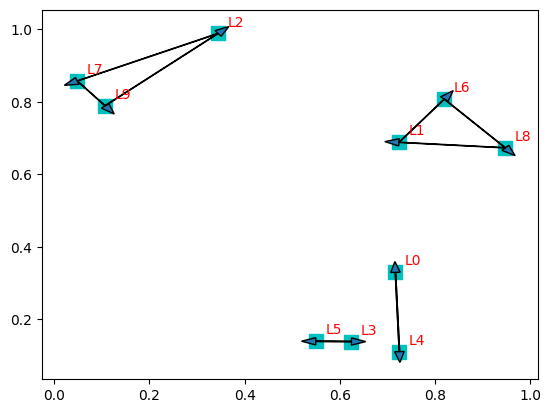

In [110]:
plt.scatter(data["x"], data["y"],c='c', marker='s', s=100)
for i in range(0,len(data)):
    plt.annotate(data['location'].values[i], (data["x"].iloc[i]+0.02, data["y"].iloc[i]+0.02), color='red') 
 
for row in path_solution.itertuples():
    x=row.origin_x
    y=row.origin_y

    dx=row.destination_x - row.origin_x
    dy=row.destination_y - row.origin_y
    
    plt.arrow(x, y, dx, dy, head_width=.02)    

In [106]:
data

,location,x,y
0,L0,0.716894,0.329482
1,L1,0.724364,0.688212
2,L2,0.344161,0.988542
3,L3,0.624408,0.138690
4,L4,0.725201,0.110867
5,L5,0.549434,0.139327
6,L6,0.819578,0.807428
7,L7,0.048493,0.857596
8,L8,0.947739,0.673142
9,L9,0.106750,0.789098
